TIME SERIES UAS MACHINE LEARNING <br/>
Nama Lengkap : Gladisa Widadining Cahya <br/>
Kelas : TI2B <br/>
NIM : 4.33.21.1.11 <br/>

# Electric Production Forecast by PyTorch LSTM 

Model the Electric Production IP index in US using data from 1985 to 2017 (UCI Dataset).<br>
- PyTorch LSTM RNN :
    - Data preparation for LSTM training : scaling, reshaping
    - LSTM modeling
    - LSTM Prediction
    - LSTM Training
    - LSTM Forecast
 <br>

## Custom Functions definition

In [1]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.autograd import Variable

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from math import sqrt

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6556\4230816024.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
df=pd.read_csv('Electric_Production.csv', index_col='DATE', parse_dates=True)

In [4]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [5]:
df.columns = ['value']

In [6]:
df.tail()

,value
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


There are no missing values!

<AxesSubplot: xlabel='DATE'>

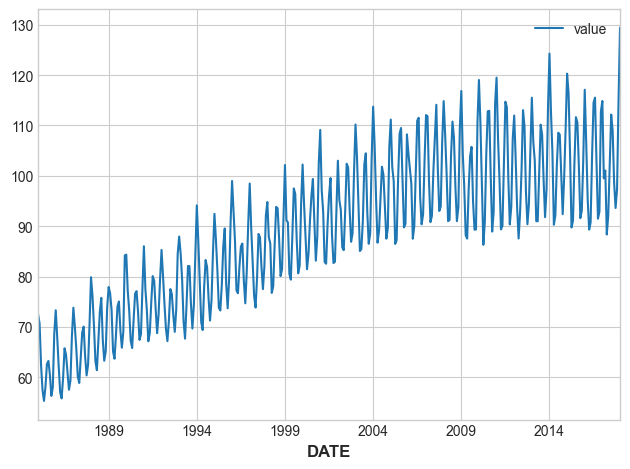

In [8]:
df.plot()


Data dapat diinterpretasikan sebagai deret waktu dengan tren positif yang jelas dan musiman. Selanjutnya, model prediksi menggunakan LSTM RNN akan dikembangkan untuk meramalkan deret waktu tersebut.

# PyTorch LSTM RNN 

Langkah pertama yang harus dilakukan adalah membentuk data masukan dengan benar. Saat memodelkan deret waktu dengan LSTM RNN, sangat penting untuk membentuk data masukan dalam format jendela geser dengan benar. Pada aplikasi ini, data diberikan dalam format bulanan. Sebagai contoh, kita dapat menggunakan jendela prediksi 12 langkah. Ini berarti kita menggunakan 12 sampel data (data selama satu tahun penuh) untuk memprediksi sampel ke-13.

In [9]:
prediction_window=12

In [10]:
n_input=12 #Use 12 months data to predict 13 th month data
n_features=1 # we are dealing with an univariate time series, so n_features should be set to 1. 
#In case of a multivariate time series, n_features should be set to a proper value higher than 1.

Kemudian kita membuat salinan bernama "train" dari kerangka data asli "df" yang akan digunakan berikut ini.

In [11]:
train = df.copy()

Menggunakan RNN disarankan untuk mengubah skala data.

In [12]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)

Sekarang kita dapat secara resmi membuat train set. Seperti yang telah disebutkan sebelumnya, rangkaian training akan memiliki bentuk ""sliding window". Artinya kita harus membentuk data sedemikian rupa sehingga RNN akan memprediksi sampel ke-13 dimulai dari sampel sebelumnya yang berjumlah 12 sampel.

In [13]:
def sliding_windows(data, n_input):
    X_train=[]
    y_train=[]
    for i in range(n_input,len(data)):
        X_train.append(data[i-n_input:i])
        y_train.append(data[i])
    return np.array(X_train), np.array(y_train)

In [14]:
x, y = sliding_windows(scaled_train, prediction_window)

In [15]:
print(f'Given the Array: \n {x[0].flatten()}')
print(f'Predict this value: \n {y[0]}')

Given the Array: 
 [0.23201741 0.20727443 0.09630353 0.02910391 0.         0.03745865
 0.09859805 0.10707831 0.07112325 0.0135012  0.03624525 0.18085375]
Predict this value: 
 [0.24282188]


In [16]:
train_size = int(len(train) - prediction_window*3)
val_size = len(train) - train_size

Kemudian kami mengonversi data ke format tensor yang dibutuhkan oleh PyTorch.

In [17]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

X_train = Variable(torch.Tensor(np.array(x[:train_size])))
y_train = Variable(torch.Tensor(np.array(y[:train_size])))

X_valid = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
y_valid = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

# LSTM Modeling

In [18]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )
        
        self.fc1 = nn.Linear(hidden_size,40)
        self.fc2 = nn.Linear(40,1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        _, (h_out,_) = self.lstm(x, (h0,c0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc2(self.relu(self.fc1(h_out)))
        
        return out

Menyiapkan untuk training:

In [19]:
EPOCHS = 2000
LEARNING_RATE = 0.008
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_SIZE = n_features
HIDDEN_SIZE = 100
NUM_LAYERS = 1

In [20]:
model = LSTMNet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
print(model)

LSTMNet(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
)


In [21]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

# LSTM Training Loop

In [22]:
early_stopping_patience = 150
early_stopping_counter = 0

valid_loss_min=np.inf

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    model.train()
    output = model(X_train)
    
    train_loss = criterion(output, y_train)
    
    train_loss.backward()
    optimizer.step()
    
    
    with torch.no_grad():
        model.eval()
        output_val = model(X_valid)
        valid_loss = criterion(output_val, y_valid)
        
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), './state_dict.pt')
            print(f'Epoch {epoch + 0:01}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
            valid_loss_min = valid_loss
            early_stopping_counter=0 #reset counter if validation loss decreases
        else:
            print(f'Epoch {epoch + 0:01}: Validation loss did not decrease')
            early_stopping_counter+=1

        if early_stopping_counter > early_stopping_patience:
            print('Early stopped at epoch :', epoch)
            break

        print(f'\t Train_Loss: {train_loss:.4f} Val_Loss: {valid_loss:.4f}  BEST VAL Loss: {valid_loss_min:.4f}\n')

Epoch 0: Validation loss decreased (inf --> 0.223230).  Saving model ...
	 Train_Loss: 0.2053 Val_Loss: 0.2232  BEST VAL Loss: 0.2232

Epoch 1: Validation loss decreased (0.223230 --> 0.089072).  Saving model ...
	 Train_Loss: 0.1084 Val_Loss: 0.0891  BEST VAL Loss: 0.0891

Epoch 2: Validation loss did not decrease
	 Train_Loss: 0.0424 Val_Loss: 0.1096  BEST VAL Loss: 0.0891

Epoch 3: Validation loss decreased (0.089072 --> 0.037391).  Saving model ...
	 Train_Loss: 0.2100 Val_Loss: 0.0374  BEST VAL Loss: 0.0374

Epoch 4: Validation loss did not decrease
	 Train_Loss: 0.0332 Val_Loss: 0.1046  BEST VAL Loss: 0.0374

Epoch 5: Validation loss did not decrease
	 Train_Loss: 0.0483 Val_Loss: 0.1438  BEST VAL Loss: 0.0374

Epoch 6: Validation loss did not decrease
	 Train_Loss: 0.0657 Val_Loss: 0.1601  BEST VAL Loss: 0.0374

Epoch 7: Validation loss did not decrease
	 Train_Loss: 0.0736 Val_Loss: 0.1624  BEST VAL Loss: 0.0374

Epoch 8: Validation loss did not decrease
	 Train_Loss: 0.0748 Va

Epoch 75: Validation loss decreased (0.020298 --> 0.020220).  Saving model ...
	 Train_Loss: 0.0112 Val_Loss: 0.0202  BEST VAL Loss: 0.0202

Epoch 76: Validation loss decreased (0.020220 --> 0.019905).  Saving model ...
	 Train_Loss: 0.0111 Val_Loss: 0.0199  BEST VAL Loss: 0.0199

Epoch 77: Validation loss decreased (0.019905 --> 0.019785).  Saving model ...
	 Train_Loss: 0.0110 Val_Loss: 0.0198  BEST VAL Loss: 0.0198

Epoch 78: Validation loss decreased (0.019785 --> 0.019747).  Saving model ...
	 Train_Loss: 0.0110 Val_Loss: 0.0197  BEST VAL Loss: 0.0197

Epoch 79: Validation loss decreased (0.019747 --> 0.019736).  Saving model ...
	 Train_Loss: 0.0110 Val_Loss: 0.0197  BEST VAL Loss: 0.0197

Epoch 80: Validation loss decreased (0.019736 --> 0.019657).  Saving model ...
	 Train_Loss: 0.0110 Val_Loss: 0.0197  BEST VAL Loss: 0.0197

Epoch 81: Validation loss decreased (0.019657 --> 0.019529).  Saving model ...
	 Train_Loss: 0.0110 Val_Loss: 0.0195  BEST VAL Loss: 0.0195

Epoch 82: Val

Epoch 137: Validation loss did not decrease
	 Train_Loss: 0.0295 Val_Loss: 0.0351  BEST VAL Loss: 0.0114

Epoch 138: Validation loss did not decrease
	 Train_Loss: 0.0162 Val_Loss: 0.0143  BEST VAL Loss: 0.0114

Epoch 139: Validation loss did not decrease
	 Train_Loss: 0.0139 Val_Loss: 0.0144  BEST VAL Loss: 0.0114

Epoch 140: Validation loss did not decrease
	 Train_Loss: 0.0223 Val_Loss: 0.0289  BEST VAL Loss: 0.0114

Epoch 141: Validation loss did not decrease
	 Train_Loss: 0.0188 Val_Loss: 0.0365  BEST VAL Loss: 0.0114

Epoch 142: Validation loss did not decrease
	 Train_Loss: 0.0198 Val_Loss: 0.0264  BEST VAL Loss: 0.0114

Epoch 143: Validation loss did not decrease
	 Train_Loss: 0.0145 Val_Loss: 0.0160  BEST VAL Loss: 0.0114

Epoch 144: Validation loss did not decrease
	 Train_Loss: 0.0089 Val_Loss: 0.0121  BEST VAL Loss: 0.0114

Epoch 145: Validation loss did not decrease
	 Train_Loss: 0.0065 Val_Loss: 0.0122  BEST VAL Loss: 0.0114

Epoch 146: Validation loss decreased (0.011407

Epoch 211: Validation loss did not decrease
	 Train_Loss: 0.0036 Val_Loss: 0.0073  BEST VAL Loss: 0.0067

Epoch 212: Validation loss did not decrease
	 Train_Loss: 0.0032 Val_Loss: 0.0077  BEST VAL Loss: 0.0067

Epoch 213: Validation loss did not decrease
	 Train_Loss: 0.0030 Val_Loss: 0.0082  BEST VAL Loss: 0.0067

Epoch 214: Validation loss did not decrease
	 Train_Loss: 0.0033 Val_Loss: 0.0085  BEST VAL Loss: 0.0067

Epoch 215: Validation loss did not decrease
	 Train_Loss: 0.0039 Val_Loss: 0.0084  BEST VAL Loss: 0.0067

Epoch 216: Validation loss did not decrease
	 Train_Loss: 0.0041 Val_Loss: 0.0079  BEST VAL Loss: 0.0067

Epoch 217: Validation loss did not decrease
	 Train_Loss: 0.0036 Val_Loss: 0.0074  BEST VAL Loss: 0.0067

Epoch 218: Validation loss did not decrease
	 Train_Loss: 0.0030 Val_Loss: 0.0069  BEST VAL Loss: 0.0067

Epoch 219: Validation loss did not decrease
	 Train_Loss: 0.0027 Val_Loss: 0.0067  BEST VAL Loss: 0.0067

Epoch 220: Validation loss did not decrease
	 

Epoch 277: Validation loss decreased (0.005697 --> 0.005688).  Saving model ...
	 Train_Loss: 0.0018 Val_Loss: 0.0057  BEST VAL Loss: 0.0057

Epoch 278: Validation loss decreased (0.005688 --> 0.005684).  Saving model ...
	 Train_Loss: 0.0018 Val_Loss: 0.0057  BEST VAL Loss: 0.0057

Epoch 279: Validation loss decreased (0.005684 --> 0.005680).  Saving model ...
	 Train_Loss: 0.0018 Val_Loss: 0.0057  BEST VAL Loss: 0.0057

Epoch 280: Validation loss decreased (0.005680 --> 0.005673).  Saving model ...
	 Train_Loss: 0.0018 Val_Loss: 0.0057  BEST VAL Loss: 0.0057

Epoch 281: Validation loss decreased (0.005673 --> 0.005667).  Saving model ...
	 Train_Loss: 0.0018 Val_Loss: 0.0057  BEST VAL Loss: 0.0057

Epoch 282: Validation loss decreased (0.005667 --> 0.005663).  Saving model ...
	 Train_Loss: 0.0018 Val_Loss: 0.0057  BEST VAL Loss: 0.0057

Epoch 283: Validation loss did not decrease
	 Train_Loss: 0.0018 Val_Loss: 0.0057  BEST VAL Loss: 0.0057

Epoch 284: Validation loss decreased (0.00

Epoch 336: Validation loss decreased (0.005139 --> 0.005131).  Saving model ...
	 Train_Loss: 0.0016 Val_Loss: 0.0051  BEST VAL Loss: 0.0051

Epoch 337: Validation loss decreased (0.005131 --> 0.005130).  Saving model ...
	 Train_Loss: 0.0016 Val_Loss: 0.0051  BEST VAL Loss: 0.0051

Epoch 338: Validation loss decreased (0.005130 --> 0.005129).  Saving model ...
	 Train_Loss: 0.0016 Val_Loss: 0.0051  BEST VAL Loss: 0.0051

Epoch 339: Validation loss decreased (0.005129 --> 0.005122).  Saving model ...
	 Train_Loss: 0.0016 Val_Loss: 0.0051  BEST VAL Loss: 0.0051

Epoch 340: Validation loss decreased (0.005122 --> 0.005105).  Saving model ...
	 Train_Loss: 0.0016 Val_Loss: 0.0051  BEST VAL Loss: 0.0051

Epoch 341: Validation loss decreased (0.005105 --> 0.005094).  Saving model ...
	 Train_Loss: 0.0016 Val_Loss: 0.0051  BEST VAL Loss: 0.0051

Epoch 342: Validation loss decreased (0.005094 --> 0.005093).  Saving model ...
	 Train_Loss: 0.0016 Val_Loss: 0.0051  BEST VAL Loss: 0.0051

Epoch 

Epoch 395: Validation loss decreased (0.004672 --> 0.004666).  Saving model ...
	 Train_Loss: 0.0014 Val_Loss: 0.0047  BEST VAL Loss: 0.0047

Epoch 396: Validation loss decreased (0.004666 --> 0.004656).  Saving model ...
	 Train_Loss: 0.0014 Val_Loss: 0.0047  BEST VAL Loss: 0.0047

Epoch 397: Validation loss decreased (0.004656 --> 0.004652).  Saving model ...
	 Train_Loss: 0.0014 Val_Loss: 0.0047  BEST VAL Loss: 0.0047

Epoch 398: Validation loss decreased (0.004652 --> 0.004640).  Saving model ...
	 Train_Loss: 0.0014 Val_Loss: 0.0046  BEST VAL Loss: 0.0046

Epoch 399: Validation loss decreased (0.004640 --> 0.004627).  Saving model ...
	 Train_Loss: 0.0014 Val_Loss: 0.0046  BEST VAL Loss: 0.0046

Epoch 400: Validation loss decreased (0.004627 --> 0.004622).  Saving model ...
	 Train_Loss: 0.0014 Val_Loss: 0.0046  BEST VAL Loss: 0.0046

Epoch 401: Validation loss decreased (0.004622 --> 0.004621).  Saving model ...
	 Train_Loss: 0.0014 Val_Loss: 0.0046  BEST VAL Loss: 0.0046

Epoch 

Epoch 466: Validation loss did not decrease
	 Train_Loss: 0.0013 Val_Loss: 0.0045  BEST VAL Loss: 0.0042

Epoch 467: Validation loss did not decrease
	 Train_Loss: 0.0014 Val_Loss: 0.0045  BEST VAL Loss: 0.0042

Epoch 468: Validation loss did not decrease
	 Train_Loss: 0.0013 Val_Loss: 0.0046  BEST VAL Loss: 0.0042

Epoch 469: Validation loss did not decrease
	 Train_Loss: 0.0013 Val_Loss: 0.0046  BEST VAL Loss: 0.0042

Epoch 470: Validation loss did not decrease
	 Train_Loss: 0.0014 Val_Loss: 0.0045  BEST VAL Loss: 0.0042

Epoch 471: Validation loss did not decrease
	 Train_Loss: 0.0013 Val_Loss: 0.0044  BEST VAL Loss: 0.0042

Epoch 472: Validation loss did not decrease
	 Train_Loss: 0.0013 Val_Loss: 0.0044  BEST VAL Loss: 0.0042

Epoch 473: Validation loss did not decrease
	 Train_Loss: 0.0013 Val_Loss: 0.0045  BEST VAL Loss: 0.0042

Epoch 474: Validation loss did not decrease
	 Train_Loss: 0.0013 Val_Loss: 0.0045  BEST VAL Loss: 0.0042

Epoch 475: Validation loss did not decrease
	 

Epoch 539: Validation loss decreased (0.004049 --> 0.004046).  Saving model ...
	 Train_Loss: 0.0011 Val_Loss: 0.0040  BEST VAL Loss: 0.0040

Epoch 540: Validation loss did not decrease
	 Train_Loss: 0.0011 Val_Loss: 0.0041  BEST VAL Loss: 0.0040

Epoch 541: Validation loss did not decrease
	 Train_Loss: 0.0011 Val_Loss: 0.0041  BEST VAL Loss: 0.0040

Epoch 542: Validation loss did not decrease
	 Train_Loss: 0.0011 Val_Loss: 0.0041  BEST VAL Loss: 0.0040

Epoch 543: Validation loss did not decrease
	 Train_Loss: 0.0011 Val_Loss: 0.0041  BEST VAL Loss: 0.0040

Epoch 544: Validation loss did not decrease
	 Train_Loss: 0.0011 Val_Loss: 0.0041  BEST VAL Loss: 0.0040

Epoch 545: Validation loss did not decrease
	 Train_Loss: 0.0011 Val_Loss: 0.0041  BEST VAL Loss: 0.0040

Epoch 546: Validation loss did not decrease
	 Train_Loss: 0.0011 Val_Loss: 0.0041  BEST VAL Loss: 0.0040

Epoch 547: Validation loss did not decrease
	 Train_Loss: 0.0011 Val_Loss: 0.0041  BEST VAL Loss: 0.0040

Epoch 548:

Epoch 613: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 614: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0041  BEST VAL Loss: 0.0039

Epoch 615: Validation loss did not decrease
	 Train_Loss: 0.0011 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 616: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0040  BEST VAL Loss: 0.0039

Epoch 617: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0041  BEST VAL Loss: 0.0039

Epoch 618: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 619: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0040  BEST VAL Loss: 0.0039

Epoch 620: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0040  BEST VAL Loss: 0.0039

Epoch 621: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 622: Validation loss did not decrease
	 

Epoch 692: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 693: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 694: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 695: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 696: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 697: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 698: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 699: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 700: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0039  BEST VAL Loss: 0.0039

Epoch 701: Validation loss did not decrease
	 

Epoch 766: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0038  BEST VAL Loss: 0.0038

Epoch 767: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0038  BEST VAL Loss: 0.0038

Epoch 768: Validation loss decreased (0.003771 --> 0.003764).  Saving model ...
	 Train_Loss: 0.0010 Val_Loss: 0.0038  BEST VAL Loss: 0.0038

Epoch 769: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0038  BEST VAL Loss: 0.0038

Epoch 770: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0038  BEST VAL Loss: 0.0038

Epoch 771: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0038  BEST VAL Loss: 0.0038

Epoch 772: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.0038  BEST VAL Loss: 0.0038

Epoch 773: Validation loss decreased (0.003764 --> 0.003761).  Saving model ...
	 Train_Loss: 0.0010 Val_Loss: 0.0038  BEST VAL Loss: 0.0038

Epoch 774: Validation loss did not decrease
	 Train_Loss: 0.0010 Val_Loss: 0.003

Epoch 841: Validation loss decreased (0.003679 --> 0.003675).  Saving model ...
	 Train_Loss: 0.0009 Val_Loss: 0.0037  BEST VAL Loss: 0.0037

Epoch 842: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0037  BEST VAL Loss: 0.0037

Epoch 843: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0037  BEST VAL Loss: 0.0037

Epoch 844: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0037  BEST VAL Loss: 0.0037

Epoch 845: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0037  BEST VAL Loss: 0.0037

Epoch 846: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0037  BEST VAL Loss: 0.0037

Epoch 847: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0037  BEST VAL Loss: 0.0037

Epoch 848: Validation loss decreased (0.003675 --> 0.003675).  Saving model ...
	 Train_Loss: 0.0009 Val_Loss: 0.0037  BEST VAL Loss: 0.0037

Epoch 849: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.003

Epoch 914: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0037  BEST VAL Loss: 0.0035

Epoch 915: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0035  BEST VAL Loss: 0.0035

Epoch 916: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0036  BEST VAL Loss: 0.0035

Epoch 917: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0036  BEST VAL Loss: 0.0035

Epoch 918: Validation loss decreased (0.003541 --> 0.003524).  Saving model ...
	 Train_Loss: 0.0009 Val_Loss: 0.0035  BEST VAL Loss: 0.0035

Epoch 919: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0037  BEST VAL Loss: 0.0035

Epoch 920: Validation loss decreased (0.003524 --> 0.003505).  Saving model ...
	 Train_Loss: 0.0009 Val_Loss: 0.0035  BEST VAL Loss: 0.0035

Epoch 921: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0036  BEST VAL Loss: 0.0035

Epoch 922: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.003

Epoch 988: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0034  BEST VAL Loss: 0.0034

Epoch 989: Validation loss decreased (0.003385 --> 0.003378).  Saving model ...
	 Train_Loss: 0.0009 Val_Loss: 0.0034  BEST VAL Loss: 0.0034

Epoch 990: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0035  BEST VAL Loss: 0.0034

Epoch 991: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0034  BEST VAL Loss: 0.0034

Epoch 992: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0035  BEST VAL Loss: 0.0034

Epoch 993: Validation loss decreased (0.003378 --> 0.003369).  Saving model ...
	 Train_Loss: 0.0009 Val_Loss: 0.0034  BEST VAL Loss: 0.0034

Epoch 994: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0035  BEST VAL Loss: 0.0034

Epoch 995: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0034  BEST VAL Loss: 0.0034

Epoch 996: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.003

Epoch 1064: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0033

Epoch 1065: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0033

Epoch 1066: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0033

Epoch 1067: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0033

Epoch 1068: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0033

Epoch 1069: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0033

Epoch 1070: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0033

Epoch 1071: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0034  BEST VAL Loss: 0.0033

Epoch 1072: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0033

Epoch 1073: Validation loss did not d

Epoch 1141: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0032

Epoch 1142: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0032  BEST VAL Loss: 0.0032

Epoch 1143: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0032

Epoch 1144: Validation loss decreased (0.003173 --> 0.003163).  Saving model ...
	 Train_Loss: 0.0008 Val_Loss: 0.0032  BEST VAL Loss: 0.0032

Epoch 1145: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0034  BEST VAL Loss: 0.0032

Epoch 1146: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0032  BEST VAL Loss: 0.0032

Epoch 1147: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0032

Epoch 1148: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0032  BEST VAL Loss: 0.0032

Epoch 1149: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0032  BEST VAL Loss: 0.0032

E

Epoch 1216: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0031  BEST VAL Loss: 0.0031

Epoch 1217: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0031

Epoch 1218: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0031  BEST VAL Loss: 0.0031

Epoch 1219: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0031

Epoch 1220: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0031  BEST VAL Loss: 0.0031

Epoch 1221: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0032  BEST VAL Loss: 0.0031

Epoch 1222: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0031  BEST VAL Loss: 0.0031

Epoch 1223: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0032  BEST VAL Loss: 0.0031

Epoch 1224: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0032  BEST VAL Loss: 0.0031

Epoch 1225: Validation loss did not d

Epoch 1295: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0032  BEST VAL Loss: 0.0030

Epoch 1296: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0031  BEST VAL Loss: 0.0030

Epoch 1297: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0032  BEST VAL Loss: 0.0030

Epoch 1298: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0030  BEST VAL Loss: 0.0030

Epoch 1299: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0031  BEST VAL Loss: 0.0030

Epoch 1300: Validation loss decreased (0.002993 --> 0.002988).  Saving model ...
	 Train_Loss: 0.0007 Val_Loss: 0.0030  BEST VAL Loss: 0.0030

Epoch 1301: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0031  BEST VAL Loss: 0.0030

Epoch 1302: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0032  BEST VAL Loss: 0.0030

Epoch 1303: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0031  BEST VAL Loss: 0.0030

E

Epoch 1370: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0030  BEST VAL Loss: 0.0029

Epoch 1371: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0030  BEST VAL Loss: 0.0029

Epoch 1372: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0030  BEST VAL Loss: 0.0029

Epoch 1373: Validation loss decreased (0.002906 --> 0.002891).  Saving model ...
	 Train_Loss: 0.0007 Val_Loss: 0.0029  BEST VAL Loss: 0.0029

Epoch 1374: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0031  BEST VAL Loss: 0.0029

Epoch 1375: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0029  BEST VAL Loss: 0.0029

Epoch 1376: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0032  BEST VAL Loss: 0.0029

Epoch 1377: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0029  BEST VAL Loss: 0.0029

Epoch 1378: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0032  BEST VAL Loss: 0.0029

E

Epoch 1447: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0031  BEST VAL Loss: 0.0028

Epoch 1448: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0028  BEST VAL Loss: 0.0028

Epoch 1449: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0029  BEST VAL Loss: 0.0028

Epoch 1450: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0029  BEST VAL Loss: 0.0028

Epoch 1451: Validation loss decreased (0.002813 --> 0.002807).  Saving model ...
	 Train_Loss: 0.0007 Val_Loss: 0.0028  BEST VAL Loss: 0.0028

Epoch 1452: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0030  BEST VAL Loss: 0.0028

Epoch 1453: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0029  BEST VAL Loss: 0.0028

Epoch 1454: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0030  BEST VAL Loss: 0.0028

Epoch 1455: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0029  BEST VAL Loss: 0.0028

E

Epoch 1524: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0028  BEST VAL Loss: 0.0027

Epoch 1525: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0029  BEST VAL Loss: 0.0027

Epoch 1526: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0028  BEST VAL Loss: 0.0027

Epoch 1527: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0028  BEST VAL Loss: 0.0027

Epoch 1528: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0028  BEST VAL Loss: 0.0027

Epoch 1529: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0027  BEST VAL Loss: 0.0027

Epoch 1530: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0028  BEST VAL Loss: 0.0027

Epoch 1531: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0028  BEST VAL Loss: 0.0027

Epoch 1532: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0028  BEST VAL Loss: 0.0027

Epoch 1533: Validation loss did not d

Epoch 1599: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0026  BEST VAL Loss: 0.0026

Epoch 1600: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0029  BEST VAL Loss: 0.0026

Epoch 1601: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0027  BEST VAL Loss: 0.0026

Epoch 1602: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0029  BEST VAL Loss: 0.0026

Epoch 1603: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0027  BEST VAL Loss: 0.0026

Epoch 1604: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0028  BEST VAL Loss: 0.0026

Epoch 1605: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0027  BEST VAL Loss: 0.0026

Epoch 1606: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0027  BEST VAL Loss: 0.0026

Epoch 1607: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0028  BEST VAL Loss: 0.0026

Epoch 1608: Validation loss did not d

Epoch 1676: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0026  BEST VAL Loss: 0.0025

Epoch 1677: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0029  BEST VAL Loss: 0.0025

Epoch 1678: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0026  BEST VAL Loss: 0.0025

Epoch 1679: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0033  BEST VAL Loss: 0.0025

Epoch 1680: Validation loss decreased (0.002543 --> 0.002539).  Saving model ...
	 Train_Loss: 0.0009 Val_Loss: 0.0025  BEST VAL Loss: 0.0025

Epoch 1681: Validation loss did not decrease
	 Train_Loss: 0.0009 Val_Loss: 0.0027  BEST VAL Loss: 0.0025

Epoch 1682: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0029  BEST VAL Loss: 0.0025

Epoch 1683: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0026  BEST VAL Loss: 0.0025

Epoch 1684: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0028  BEST VAL Loss: 0.0025

E

Epoch 1753: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0028  BEST VAL Loss: 0.0025

Epoch 1754: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0027  BEST VAL Loss: 0.0025

Epoch 1755: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0028  BEST VAL Loss: 0.0025

Epoch 1756: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0026  BEST VAL Loss: 0.0025

Epoch 1757: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0029  BEST VAL Loss: 0.0025

Epoch 1758: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0026  BEST VAL Loss: 0.0025

Epoch 1759: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0027  BEST VAL Loss: 0.0025

Epoch 1760: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0027  BEST VAL Loss: 0.0025

Epoch 1761: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0026  BEST VAL Loss: 0.0025

Epoch 1762: Validation loss did not d

Epoch 1832: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0026  BEST VAL Loss: 0.0025

Epoch 1833: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0027  BEST VAL Loss: 0.0025

Epoch 1834: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0026  BEST VAL Loss: 0.0025

Epoch 1835: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0026  BEST VAL Loss: 0.0025

Epoch 1836: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0027  BEST VAL Loss: 0.0025

Epoch 1837: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0026  BEST VAL Loss: 0.0025

Epoch 1838: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0027  BEST VAL Loss: 0.0025

Epoch 1839: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0025  BEST VAL Loss: 0.0025

Epoch 1840: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0028  BEST VAL Loss: 0.0025

Epoch 1841: Validation loss did not d

Epoch 1908: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0029  BEST VAL Loss: 0.0024

Epoch 1909: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0025  BEST VAL Loss: 0.0024

Epoch 1910: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0025  BEST VAL Loss: 0.0024

Epoch 1911: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0027  BEST VAL Loss: 0.0024

Epoch 1912: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0027  BEST VAL Loss: 0.0024

Epoch 1913: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0027  BEST VAL Loss: 0.0024

Epoch 1914: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0025  BEST VAL Loss: 0.0024

Epoch 1915: Validation loss did not decrease
	 Train_Loss: 0.0006 Val_Loss: 0.0025  BEST VAL Loss: 0.0024

Epoch 1916: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0025  BEST VAL Loss: 0.0024

Epoch 1917: Validation loss did not d

Epoch 1988: Validation loss did not decrease
	 Train_Loss: 0.0004 Val_Loss: 0.0025  BEST VAL Loss: 0.0024

Epoch 1989: Validation loss did not decrease
	 Train_Loss: 0.0004 Val_Loss: 0.0026  BEST VAL Loss: 0.0024

Epoch 1990: Validation loss did not decrease
	 Train_Loss: 0.0004 Val_Loss: 0.0026  BEST VAL Loss: 0.0024

Epoch 1991: Validation loss did not decrease
	 Train_Loss: 0.0004 Val_Loss: 0.0027  BEST VAL Loss: 0.0024

Epoch 1992: Validation loss decreased (0.002381 --> 0.002375).  Saving model ...
	 Train_Loss: 0.0005 Val_Loss: 0.0024  BEST VAL Loss: 0.0024

Epoch 1993: Validation loss did not decrease
	 Train_Loss: 0.0005 Val_Loss: 0.0030  BEST VAL Loss: 0.0024

Epoch 1994: Validation loss did not decrease
	 Train_Loss: 0.0007 Val_Loss: 0.0024  BEST VAL Loss: 0.0024

Epoch 1995: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0033  BEST VAL Loss: 0.0024

Epoch 1996: Validation loss did not decrease
	 Train_Loss: 0.0008 Val_Loss: 0.0025  BEST VAL Loss: 0.0024

E

# LSTM Prediction

Check the values predicted by the LSTM RNN on the validation data

In [23]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

In [24]:
valid_predict = model(X_valid)
y_pred_scaled = valid_predict.data.numpy()
y_pred = scaler.inverse_transform(y_pred_scaled)

In [25]:
df_pred=train.iloc[-24:]
df_pred['prediction']=y_pred

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6556\1916461793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['prediction']=y_pred


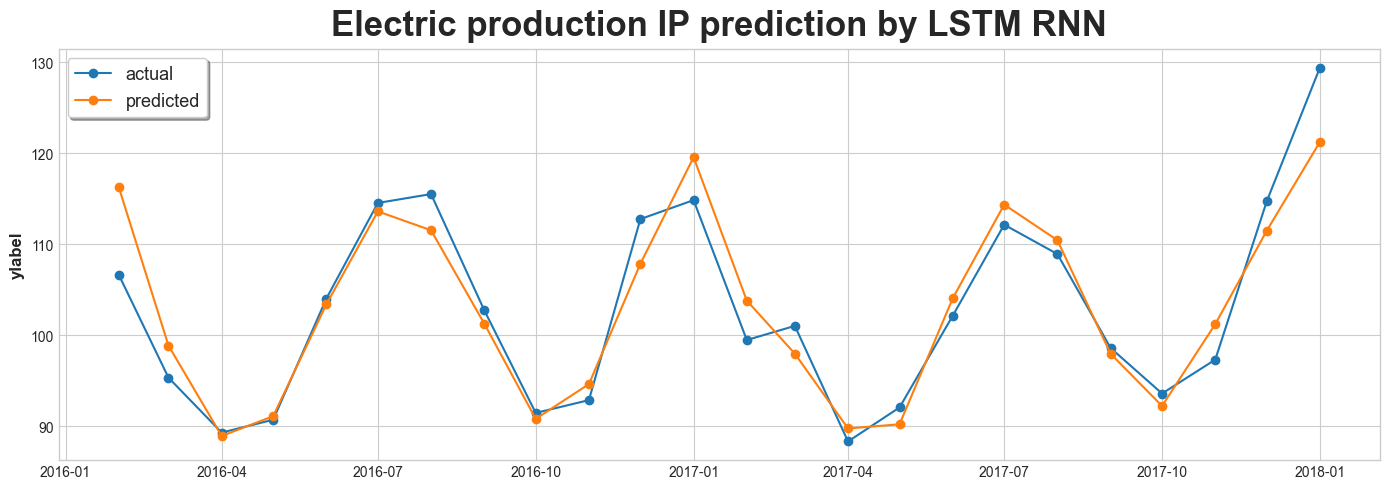

In [26]:
plt.figure(figsize=(14,5))
plt.plot(df_pred.index,df_pred["value"], label="actual", marker="o")
plt.plot(df_pred.index,df_pred["prediction"], label="predicted", marker="o")
plt.title("Electric production IP prediction by LSTM RNN", fontsize=25)
plt.ylabel("ylabel")
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

In [27]:
mape_lstm = mape(df_pred["value"], df_pred["prediction"])
print(f"MAPE OF LSTM MODEL : {mape_lstm:.2f} %")

MAPE OF LSTM MODEL : 2.60 %


In [28]:
rmse_lstm = mean_squared_error(df_pred["value"], df_pred["prediction"], squared=False)
print(f"RMSE OF LSTM MODEL : {rmse_lstm:.2f}")

RMSE OF LSTM MODEL : 3.61


*Hasil terlihat hampir sama untuk rmse and mape.**

# LSTM Forecasting

In [29]:
test_predictions = []

first_eval_batch = Variable(torch.Tensor(scaled_train[-n_input:])) # use the previous 12 samples to predict the 13th
current_batch=first_eval_batch.reshape((1,n_input,n_features)) # reshape the data into (1,12,1)
for i in range(len(scaled_train[-n_input:])):
    #get the prediction value for the first batch
    current_pred = model(current_batch)
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = torch.cat((current_batch[:,1:,:],current_pred.reshape(1,1,1)),1)

In [30]:
forec_vals = [val.flatten().item() for val in test_predictions]
forec_vals = np.array(forec_vals).reshape(-1,1)
forec_vals = scaler.inverse_transform(forec_vals)

In [31]:
date_offset=12
forecast_dates =  (train.index + pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [32]:
df_forecast=pd.DataFrame({'date': forecast_dates})
df_forecast.set_index('date', inplace=True)
df_forecast['prediction'] = forec_vals
df_forecast.head(12)

,prediction
date,
2018-02-01,110.557576
2018-03-01,103.036162
2018-04-01,90.464233
2018-05-01,93.474178
2018-06-01,104.903956
2018-07-01,114.874322
2018-08-01,107.833868
2018-09-01,99.395634
2018-10-01,90.854430


In [33]:
df_full=df_pred.append(df_forecast)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6556\4117998763.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full=df_pred.append(df_forecast)


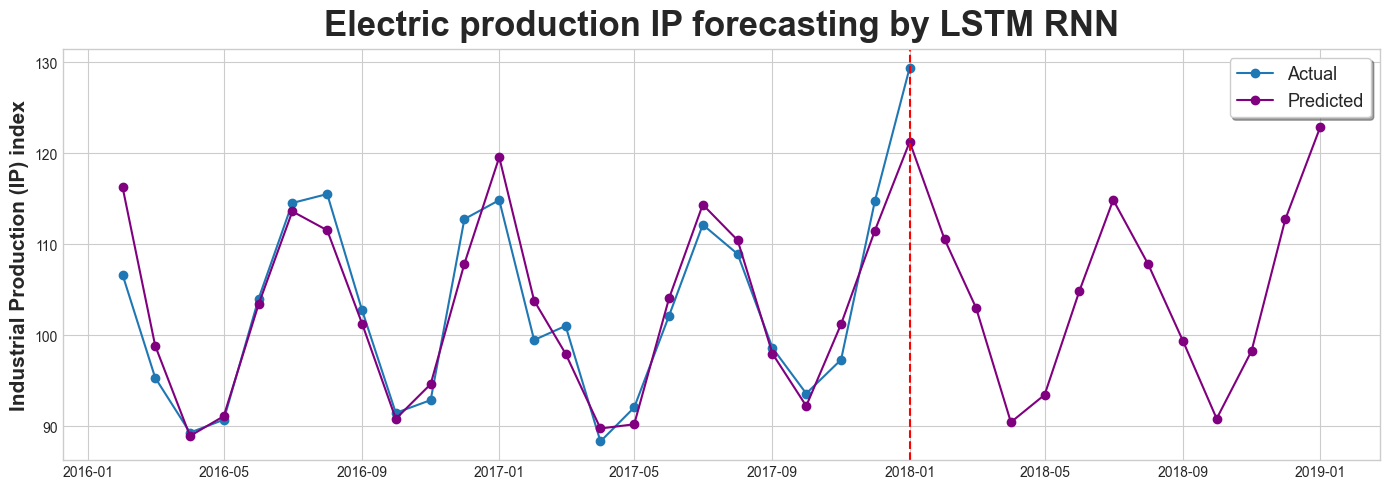

In [34]:
plt.figure(figsize=(14,5))
plt.plot(df_full.index,df_full["value"], label="Actual", marker="o")
plt.plot(df_full.index,df_full["prediction"], label="Predicted", marker="o", color="purple")
plt.axvline(df_pred.index[-1], color="red", linestyle="--")
plt.title("Electric production IP forecasting by LSTM RNN", fontsize=25)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()